# QRT Data Challenge 2020: Stock Return Prediction

The proposed challenge aims at predicting the return of a stock in the US market using historical data over a recent period of 20 days.

Public score for the first attempt was 0.5178, which granted me the 20th place out of 207 contestants.
https://challengedata.ens.fr/participants/challenges/23/ranking/public

Improvements to be tried in the future:
- More feature engineering
- Tune the hyperparameters with a gridsearch (need a more powerful computer)
- Try other models
- Try mixing models (ML + deep learning + SVR)

## Libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Loading the data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('./x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


## Dataset analysis

### Exploration

The dataset is made of 46 descriptive features:

- DATE: an index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates),
- STOCK: an index of the stock,
- INDUSTRY: an index of the stock industry domain (e.g., aeronautic, IT, oil company),
- INDUSTRY_GROUP: an index of the group industry,
- SUB_INDUSTRY: a lower level index of the industry,
- SECTOR: an index of the work sector,
- RET_1 to RET_20: the historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on),
- VOLUME_1 to VOLUME_20: the historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on)

And 1 target variable:

- RET: True if the stock return is in the top 50% of highest stock returns

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6  

Every descriptive feature is a float number, while the target variable is a boolean.

### NaN values

Moreover, we notice that the non-null count is inconsistent throughout the features. Let's look at the NaN values.

In [4]:
train.isna().sum()

DATE                  0
STOCK                 0
INDUSTRY              0
INDUSTRY_GROUP        0
SECTOR                0
SUB_INDUSTRY          0
RET_1              2359
VOLUME_1          65025
RET_2              2465
VOLUME_2          66386
RET_3              2507
VOLUME_3          67819
RET_4              2544
VOLUME_4          70997
RET_5              2584
VOLUME_5          74693
RET_6              2597
VOLUME_6          74714
RET_7              2585
VOLUME_7          73853
RET_8              2623
VOLUME_8          73898
RET_9              2682
VOLUME_9          73298
RET_10             2692
VOLUME_10         73305
RET_11             2961
VOLUME_11         72025
RET_12             3186
VOLUME_12         62523
RET_13             3360
VOLUME_13         59008
RET_14             4413
VOLUME_14         60929
RET_15             4990
VOLUME_15         66373
RET_16             5280
VOLUME_16         67262
RET_17             5301
VOLUME_17         62314
RET_18             5307
VOLUME_18       

In [5]:
(train.isna().sum()/len(train))*100

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET_6              0.620409
VOLUME_6          17.848756
RET_7              0.617542
VOLUME_7          17.643068
RET_8              0.626620
VOLUME_8          17.653818
RET_9              0.640715
VOLUME_9          17.510481
RET_10             0.643104
VOLUME_10         17.512154
RET_11             0.707366
VOLUME_11         17.206369
RET_12             0.761118
VOLUME_12         14.936394
RET_13             0.802685
VOLUME_13         14.096681
RET_14             1.054241
VOLUME_14         14.555597
RET_15             1.192083
VOLUME_15         15

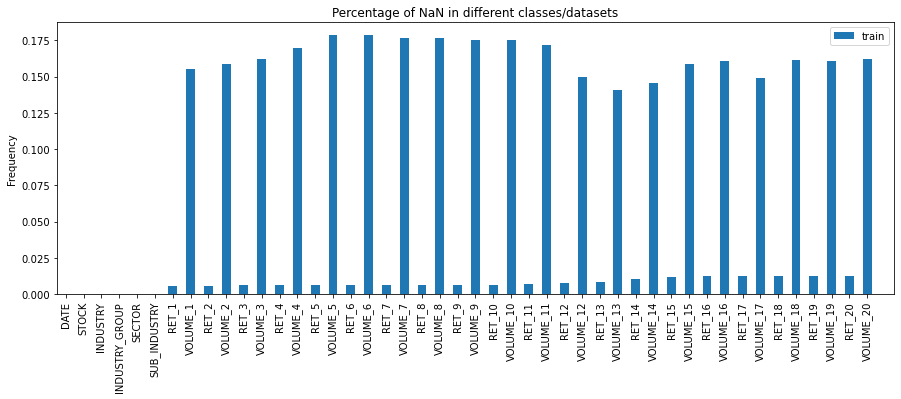

In [6]:
plt.figure(figsize=(15, 5))
(train.isna().sum() / len(train)).plot(label='train', use_index=False, kind = 'bar')
plt.xticks(np.arange(46), train.columns, rotation=90)
plt.ylabel('Frequency')
plt.title("Percentage of NaN in different classes/datasets")
plt.legend()
plt.show()

There is a non negligible amount of NaN values throughout the dataset, counting for nearly 15% of the VOLUME columns and 1% of the RET columns. These values can't be dropped, meaning that we will need to find a way to treat with these values later on.

Most of the NaN are localized in the VOLUME columns. This can be because relative volumes are computed using the median. The way the median function is implemented in python could cause the apparition of many NaN values: if we compute the relative volume over a period of 20 days and there is one NaN value at a day D, the relative volume will show NaN values from day D to day D+20.

Moreover, NaN values in the RET columns can come from the nature of the stock market data: the market closes on some days (weekends, public holidays, etc). This could also apply to the relative volume, and contribue to the high amount of NaN values.

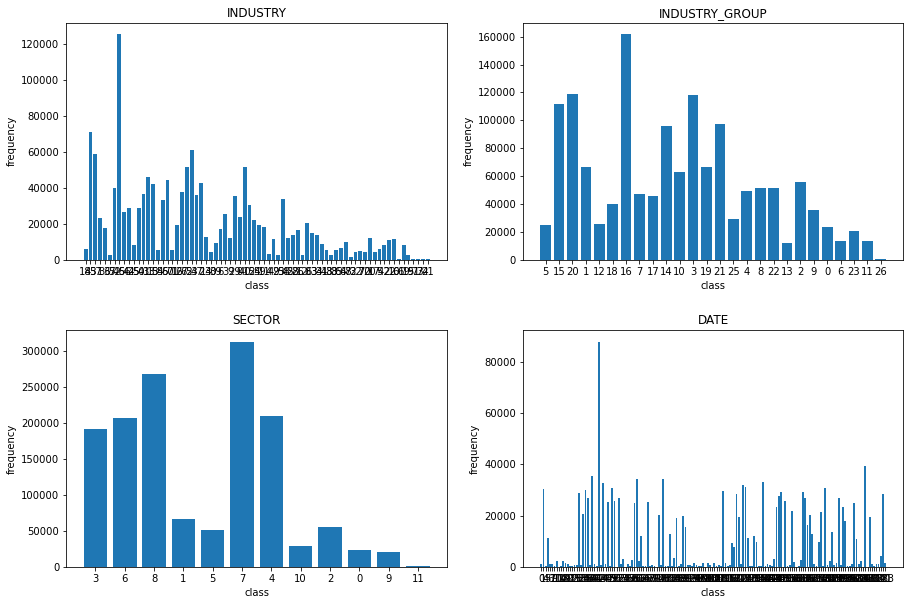

In [7]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)

for i, col in zip(range(1, 5), ['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'DATE']):
    plt.subplot(2, 2, i)
    dic = {}
    for k in train[col].unique():
        dic[k] = sum(train[train[col] == k].isna().sum())
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.xlabel('class')
    plt.ylabel('frequency')
    plt.title(col)

plt.show()

We notice that the amount of NaN per category is very variable, which shows that some industries / groups are more prone to seeing NaN values than others.

However, some days seem to have a higher amount of NaN values than others. This might be because of longer public holidays where the market closes.

### Dataset balance

Let's also have a look at how balanced the data is.

In [8]:
train['RET'].value_counts(normalize = True)*100

False    50.107861
True     49.892139
Name: RET, dtype: float64

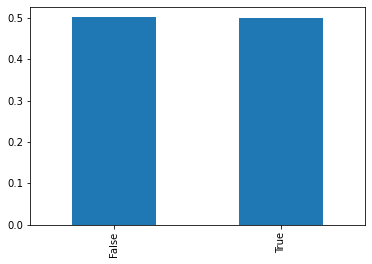

In [9]:
train['RET'].value_counts(normalize = True).plot(kind = 'bar')

The target output seems balanced. We can therefore afford to use a conventional approach to the problem, putting inbalance-related issues aside.

### Statistics

In [10]:
train.describe()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,413315.000000,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,0.001074,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,0.029538,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-0.765478,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.010527,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,0.000530,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.012084,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795
max,223.000000,5716.000000,74.000000,26.000000,11.000000,182.000000,1.444990,1232.174009,1.427746,632.268279,...,1.028902,355.613431,1.707736,408.771698,6.000004,788.461460,2.954430,631.249564,7.208859,932.939205


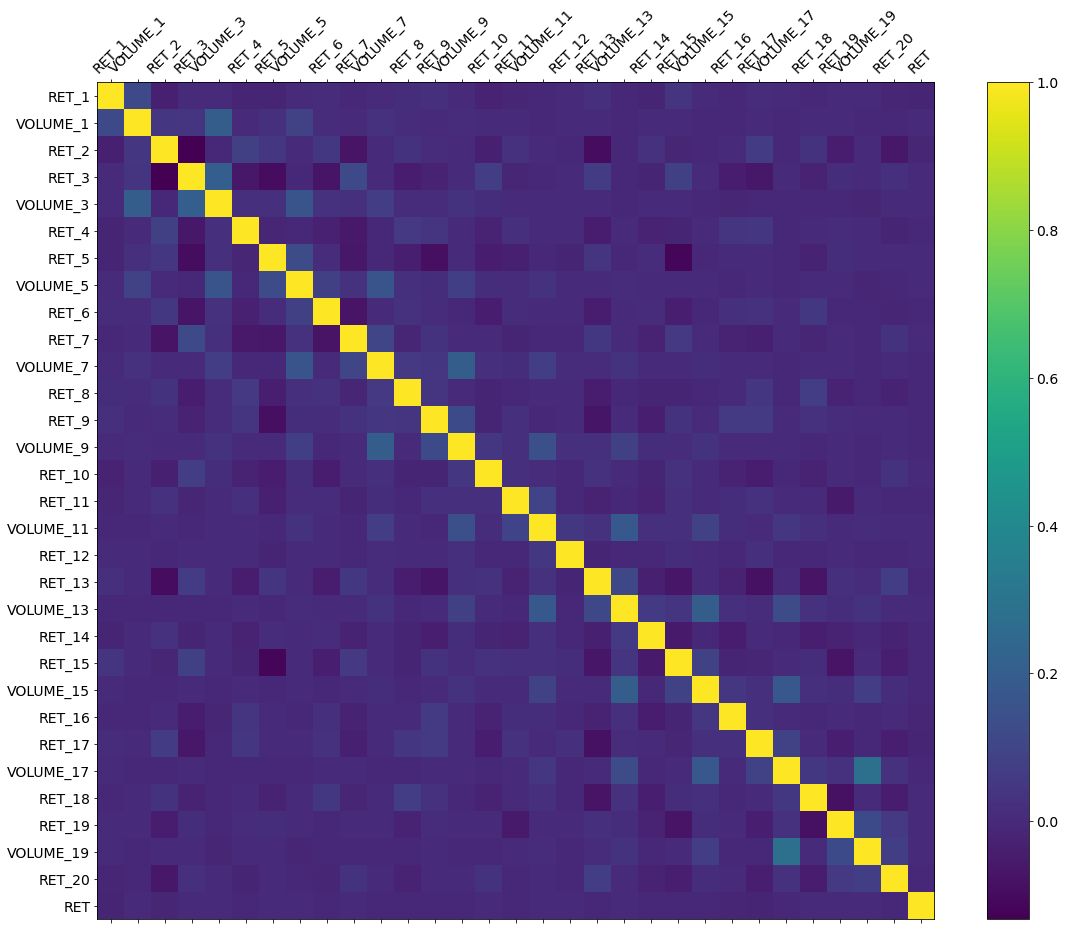

In [11]:
to_drop = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR','SUB_INDUSTRY']

for col in ['VOLUME_' + str(i) for i in range(2, 21, 2)]:
    to_drop += [col]

fig = plt.figure(figsize = (19, 15))
plt.matshow(train.drop(to_drop, axis = 1).corr(), fignum = fig.number)
plt.xticks(range(train.drop(to_drop, axis = 1).shape[1]), train.drop(to_drop, axis = 1).columns, fontsize = 14, rotation = 45)
plt.yticks(range(train.drop(to_drop, axis = 1).shape[1]), train.drop(to_drop, axis = 1).columns, fontsize = 14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.show()

There seem to be no outlier or surprising values. We can therefore assume that apart from the NaN issue, the dataset requieres minimum cleaning. Moreover, all the features seem to be uncorrelated, so no conclusion can be made at this point.

## Data cleaning

### Dealing with the NaN values

As a reminder, the `VOLUME` columns are showing the relative volume. One way to overcome the NaN values could be to recompute these using the nanmedian function from the numpy library, as this function computes the median over a period ignoring the NaN values.  
However, to do this, we'd need to know the totam trade volume among the 20 stocks at a time step t, which we don't have.  

Let's visualize where the NaN values are located on one of the `VOLUME` columns: An easy way would be to fill the NaN values with an absurd number and see the outliers on the chart.

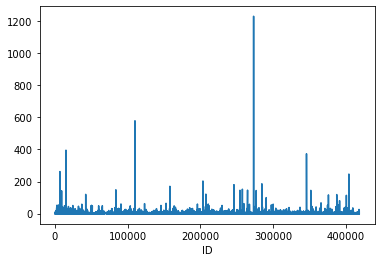

In [12]:
train['VOLUME_1'].fillna(value = 0).plot()

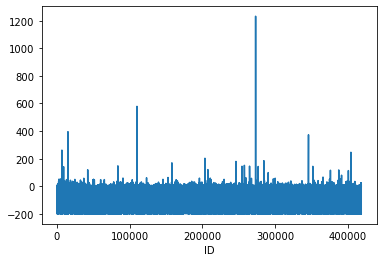

In [13]:
train['VOLUME_1'].fillna(value = -200).plot()

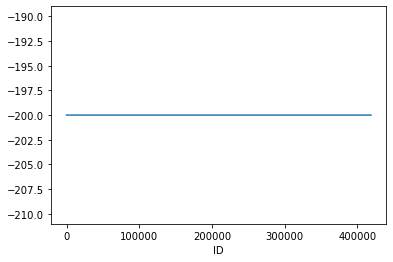

In [14]:
train['VOLUME_1'].fillna(value = -200)[train['VOLUME_1'].fillna(value = -200) < -100].plot()

We can see that the NaN values appear pretty much constantly and randomly throughout the whole dataset.

In [15]:
train['VOLUME_1'].mean()

-0.07150157604248453

In [16]:
train['VOLUME_1'].std()

3.0386579280309705

Seeing that the mean is -0.07 and the std is 3.04, we can suppose that the following methods could be a good fit for filling the NaNs without bringing too much error in the dataset:  
- Fill the NaN values with 0
- Fill the NaN values with the mean (either rolling or over the whole colum)
- Interpolate every NaN with the closest non NaN values (although not optimal if there are too many consecutive NaNs)  

Let's use the average.

In [17]:
for column in train:
    train[column] = train[column].fillna(train[column].mean())

In [18]:
train.isna().sum()

DATE              0
STOCK             0
INDUSTRY          0
INDUSTRY_GROUP    0
SECTOR            0
SUB_INDUSTRY      0
RET_1             0
VOLUME_1          0
RET_2             0
VOLUME_2          0
RET_3             0
VOLUME_3          0
RET_4             0
VOLUME_4          0
RET_5             0
VOLUME_5          0
RET_6             0
VOLUME_6          0
RET_7             0
VOLUME_7          0
RET_8             0
VOLUME_8          0
RET_9             0
VOLUME_9          0
RET_10            0
VOLUME_10         0
RET_11            0
VOLUME_11         0
RET_12            0
VOLUME_12         0
RET_13            0
VOLUME_13         0
RET_14            0
VOLUME_14         0
RET_15            0
VOLUME_15         0
RET_16            0
VOLUME_16         0
RET_17            0
VOLUME_17         0
RET_18            0
VOLUME_18         0
RET_19            0
VOLUME_19         0
RET_20            0
VOLUME_20         0
RET               0
dtype: int64

## Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

### Weekly average and standard deviation for return

Under the assumption that 1 week = 5 days, the following code computes the weeklyu average and standard deviation of the past two weeks

In [19]:
new_features_dic = {}

for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['AVG_RET_WEEK' + str(week + 1)] = train[features].mean(axis=1)
    
new_features = pd.DataFrame(new_features_dic)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4
ID,,,,
0,-0.003694,0.059023,-0.001328,0.011270
1,-0.026274,0.038943,-0.022391,-0.012566
2,-0.006658,0.010191,-0.000870,-0.006835
3,0.003658,-0.011622,0.005285,-0.009936
4,0.002059,-0.002470,0.002895,-0.016689


In [20]:
new_features_dic = {}

for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['STD_RET_WEEK' + str(week + 1)] = train[features].std(axis=1)
    
new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4
ID,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074


### Weekly average and standard deviation for volume

In [21]:
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['AVG_VOL_WEEK' + str(week + 1)] = train[features].mean(axis=1).abs()

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4
ID,,,,,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354


In [22]:
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['STD_VOL_WEEK' + str(week + 1)] = train[features].std(axis=1)

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
new_features.head()

,AVG_RET_WEEK1,AVG_RET_WEEK2,AVG_RET_WEEK3,AVG_RET_WEEK4,STD_RET_WEEK1,STD_RET_WEEK2,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,
0,-0.003694,0.059023,-0.001328,0.011270,0.016027,0.093068,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895,0.485623,3.506872,0.750430,0.375799
1,-0.026274,0.038943,-0.022391,-0.012566,0.042498,0.072515,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571,0.011118,0.006062,0.005748,0.005193
2,-0.006658,0.010191,-0.000870,-0.006835,0.031757,0.031354,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817,0.166250,0.468279,0.124713,0.185567
3,0.003658,-0.011622,0.005285,-0.009936,0.018668,0.022146,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098,0.348658,0.530622,0.728515,0.286219
4,0.002059,-0.002470,0.002895,-0.016689,0.026294,0.021603,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354,0.194741,0.414731,8.385123,0.440387


In [23]:
new_features.shape

(418595, 16)

### Regrouping the features by SECTOR / DATE

In [24]:
# Merging the new features to train
new_train = pd.concat((train, new_features), axis=1)

# Feature engineering
new_features_list = []

# Conditional aggregated features: Average return over each SECTOR / DATE
shifts = [1,2,3,4]
statistics = ['mean']
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET_'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_train[name] = new_train.groupby(gb_features)[feat].transform(stat)

# Conditional aggregated features: Percentage of volume of each SECTOR / DATE group over the total
shifts = [1,2,3,4]
statistics = ['sum']
gb_features = ['SECTOR', 'DATE']
target_feature = 'AVG_VOL_WEEK'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_train[name] = new_train[feat] / new_train.groupby(gb_features)[feat].transform(stat)

In [25]:
new_features_list += new_features.columns.to_list()

In [26]:
new_features_list

['RET_1_SECTOR_DATE_mean',
 'RET_2_SECTOR_DATE_mean',
 'RET_3_SECTOR_DATE_mean',
 'RET_4_SECTOR_DATE_mean',
 'AVG_VOL_WEEK1_SECTOR_DATE_sum',
 'AVG_VOL_WEEK2_SECTOR_DATE_sum',
 'AVG_VOL_WEEK3_SECTOR_DATE_sum',
 'AVG_VOL_WEEK4_SECTOR_DATE_sum',
 'AVG_RET_WEEK1',
 'AVG_RET_WEEK2',
 'AVG_RET_WEEK3',
 'AVG_RET_WEEK4',
 'STD_RET_WEEK1',
 'STD_RET_WEEK2',
 'STD_RET_WEEK3',
 'STD_RET_WEEK4',
 'AVG_VOL_WEEK1',
 'AVG_VOL_WEEK2',
 'AVG_VOL_WEEK3',
 'AVG_VOL_WEEK4',
 'STD_VOL_WEEK1',
 'STD_VOL_WEEK2',
 'STD_VOL_WEEK3',
 'STD_VOL_WEEK4']

In [27]:
new_train.shape

(418595, 71)

## Feature selection

To reduce the number of feature (and the noise) we can consider ways to reduce the number of features: 
- Keep the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.
- OR/AND remove one of the features that are highly correlated
- OR perform a PCA to keep most of the information in less variables

In [28]:
n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features_list  # The conditional features
new_train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,0.035702,0.028107,0.194968,2.721878,0.760344,0.062895,0.485623,3.506872,0.750430,0.375799
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,-0.071502,-0.075230,-0.097235,-0.088976,-0.092163,...,0.019070,0.021442,0.085021,0.091055,0.079773,0.078571,0.011118,0.006062,0.005748,0.005193
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,0.016597,0.009919,0.075251,0.236733,0.216767,0.309817,0.166250,0.468279,0.124713,0.185567
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,0.011372,0.028261,0.596365,0.256153,0.876580,0.427098,0.348658,0.530622,0.728515,0.286219
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,0.054073,0.022074,1.097822,0.635516,3.913261,0.245354,0.194741,0.414731,8.385123,0.440387


In [29]:
new_train[features].shape

(418595, 34)

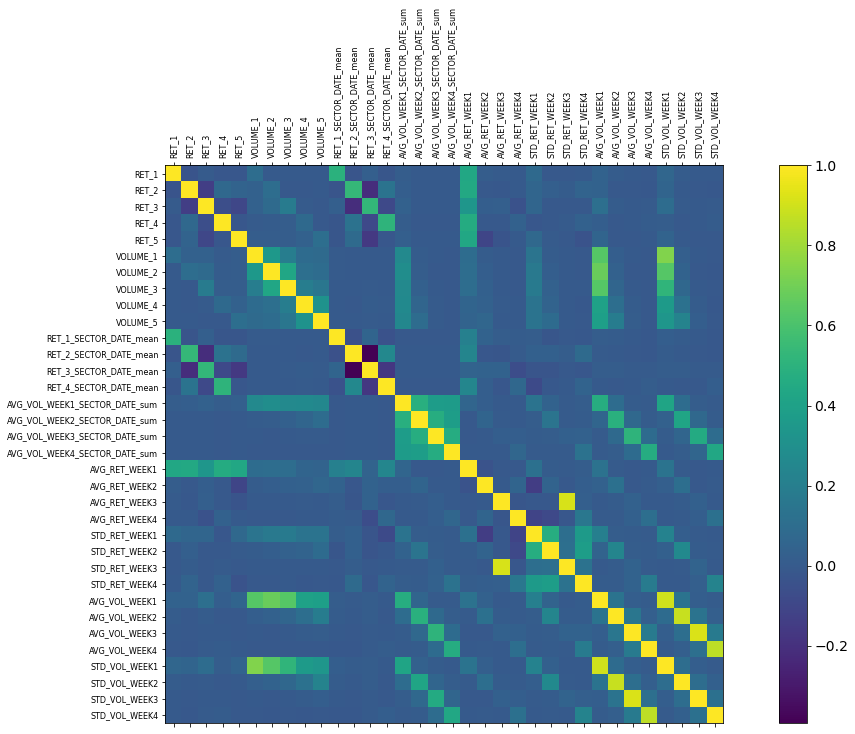

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.matshow(new_train[features].corr(), fignum = fig.number)
plt.xticks(range(new_train[features].shape[1]), new_train[features].columns, fontsize = 8, rotation = 90)
plt.yticks(range(new_train[features].shape[1]), new_train[features].columns, fontsize = 8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [31]:
new_train[features].corr()[new_train[features].corr() > 0.90]

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
RET_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RET_5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLUME_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The correlation seem below 0.9 for nearly all features, except for some values on week 3.

## Model and local score

A Random Forest (RF) model is chosen initially. We consider a large number of tree with a quiet small depth. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

In [32]:
target = 'RET'
X_train = new_train[features]
y_train = train[target]

# A quite large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 100,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.17%
Fold 2 - Accuracy: 50.73%
Fold 3 - Accuracy: 51.09%
Fold 4 - Accuracy: 51.82%
Accuracy: 51.45% [50.88 ; 52.02] (+- 0.57)


In [33]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns = new_train[features].columns)

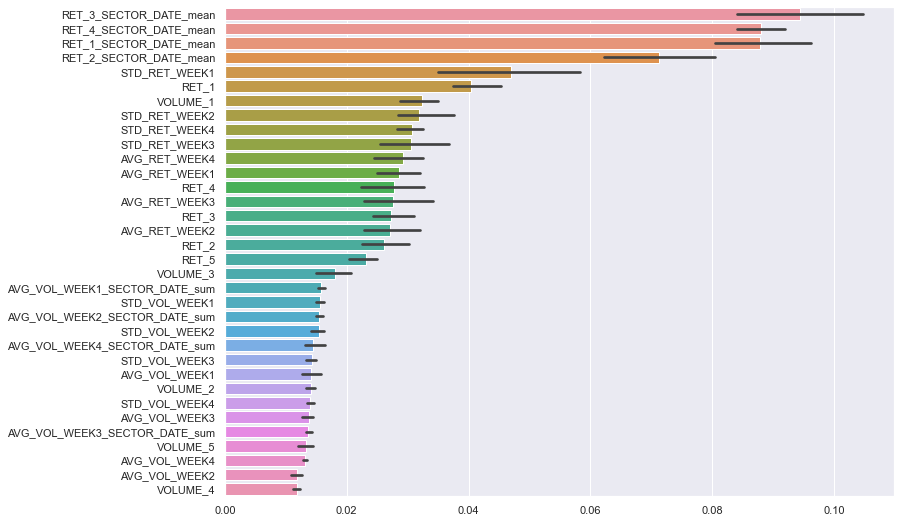

In [34]:
sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(data = feature_importances, orient='h', order = feature_importances.mean().sort_values(ascending = False).index.to_list())

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

### Reshape the test set for the predictions

In [35]:
# Add the AVG_RET_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['AVG_RET_WEEK' + str(week + 1)] = test[features].mean(axis=1)
    
new_features = pd.DataFrame(new_features_dic)

# Add the STD_RET_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('RET_' + str(week * 5 + day))
    new_features_dic['STD_RET_WEEK' + str(week + 1)] = test[features].std(axis=1)
    
new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)

# Add the AVG_VOL_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['AVG_VOL_WEEK' + str(week + 1)] = test[features].mean(axis=1).abs()

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)

# Add the STD_VOL_WEEK features
new_features_dic = {}
for week in range(4):
    features = []
    for day in range(1, 6):
        features.append('VOLUME_' + str(week * 5 + day))
    new_features_dic['STD_VOL_WEEK' + str(week + 1)] = test[features].std(axis=1)

new_features = pd.concat((new_features, pd.DataFrame(new_features_dic)), axis=1)
    
# Merge the new features to train
new_test = pd.concat((test, new_features), axis=1)

# Feature engineering
new_features_list = []

# Conditional aggregated features: Average return over each SECTOR / DATE
shifts = [1,2,3,4]
statistics = ['mean']
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET_'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_test[name] = new_test.groupby(gb_features)[feat].transform(stat)

# Conditional aggregated features: Percentage of volume of each SECTOR / DATE group over the total
shifts = [1,2,3,4]
statistics = ['sum']
gb_features = ['SECTOR', 'DATE']
target_feature = 'AVG_VOL_WEEK'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}{shift}'
        new_features_list.append(name)
        new_test[name] = new_test[feat] / new_test.groupby(gb_features)[feat].transform(stat)

new_features_list += new_features.columns.to_list()

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features_list  # The conditional features

new_test[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,STD_RET_WEEK3,STD_RET_WEEK4,AVG_VOL_WEEK1,AVG_VOL_WEEK2,AVG_VOL_WEEK3,AVG_VOL_WEEK4,STD_VOL_WEEK1,STD_VOL_WEEK2,STD_VOL_WEEK3,STD_VOL_WEEK4
ID,,,,,,,,,,,,,,,,,,,,,
418595,0.020208,0.010059,0.002192,0.001903,0.001466,0.146176,0.224756,-0.474404,0.026316,0.079495,...,0.007645,0.011190,0.000468,0.165889,0.316436,0.178251,0.275660,0.086488,0.243159,0.181370
418596,0.009134,0.021913,-0.007251,-0.017223,-0.019126,-0.251631,-0.712515,-0.328719,-0.921532,-0.857393,...,0.025084,0.003894,0.614358,0.417433,0.005741,0.339664,0.306683,0.512848,0.989235,0.425939
418597,0.005008,0.005914,-0.003927,0.000873,-0.086193,-0.115845,-0.107441,0.347900,0.731513,2.681007,...,0.004404,0.005855,0.707427,0.208218,0.033058,0.308358,1.158301,0.174638,0.287544,0.221479
418598,0.015370,-0.013738,0.008600,0.001915,0.008691,-0.090295,0.048465,-0.218245,-0.055296,0.257485,...,0.009485,0.019462,0.011577,0.050427,0.497355,0.048371,0.178058,0.807225,0.209205,0.389515
418599,0.011419,0.022807,0.014645,-0.047796,-0.010220,-0.289027,-0.262690,-0.370676,-0.107222,-0.412849,...,0.011474,0.014723,0.288493,0.579163,0.534344,0.010729,0.118051,0.242568,0.218905,0.644090


In [ ]:
X_test = new_test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./benchmark_qrt.csv', index=True, header=True)


The local accuracy is around 52. If we did not overfit, we shall expect something within the range above.

The benchmark score can be found at https://challengedata.ens.fr. It is 51.31 %.